In [ ]:
import ibm_db
import ibm_db_dbi

In [ ]:
dsn_hostname = "dal09anadbd1.na.ibm.net" # e.g.: "dashdb-txn-sbox-yp-dal09-04.services.dal.bluemix.net"
dsn_uid = "in0182h7" # e.g. "abc12345"
dsn_pwd = "Bhubaneswar9953468Delhi" # e.g. "7dBZ3wWt9XN6$o0J"
dsn_driver = "{IBM DB2 ODBC DRIVER}"
dsn_database = "POCDB"            # e.g. "BLUDB"
dsn_port = "60002"                # e.g. "50000" 
dsn_protocol = "TCPIP"

In [ ]:
dsn = (
    "DRIVER={0};"
    "DATABASE={1};"
    "HOSTNAME={2};"
    "PORT={3};"
    "PROTOCOL={4};"
    "UID={5};"
    "PWD={6};").format(dsn_driver, dsn_database, dsn_hostname, dsn_port, dsn_protocol,dsn_uid, dsn_pwd)

In [ ]:
try:
    conn = ibm_db.pconnect(dsn, "", "")
    print ("Connected to database: ", dsn_database, "as user: ", dsn_uid, "on host: ", dsn_hostname)

except:
    print ("Unable to connect: ", ibm_db.conn_errormsg() )
    
ibm_db.close(conn)



from ibmdbpy import IdaDataBase, IdaDataFrame
pconn = ibm_db_dbi.Connection(conn)


In [1]:

import time 
import random 
import datetime
from datetime import date
import pandas as pd 
import matplotlib.pyplot as plt 
import statistics 
import numpy as np 
from scipy import stats 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns
from IPython.display import Image
from scipy.stats import pointbiserialr
pd.options.display.float_format = '{:.2f}'.format
#setting dimensions for plot
sns.set(rc={'figure.figsize':(11.7,8.27)})
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
ar_AR_sample=pd.read_csv("C:/Users/YogeshGovindan/Desktop/AVNET/Model/AVENT.AR_REGRESSION.csv",index_col=0)

C:\Users\YogeshGovindan\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
#creating copy
ar_data=ar_AR_sample.copy()

In [4]:
ar_data.shape

(2809428, 25)

In [ ]:
# relative frequency of the missings per column
#missing=pd.DataFrame(ar_data.isna().sum()/(len(ar_data))*100)

In [ ]:
#missing

In [5]:
#dropping unwanted columns and Missing columns
col=['SEG_RISK_DEFAULT','SEG_PROP_PAY_VAL','ITEMNO']
ar_data=ar_data.drop(columns=col,axis=1)

In [6]:
ar_data['DOC_DATE']=pd.to_datetime(ar_data['DOC_DATE'])
ar_data['POSTINGDATE']=pd.to_datetime(ar_data['POSTINGDATE'])
ar_data['NETDUEDATE']=pd.to_datetime(ar_data['NETDUEDATE'])
ar_data['CLEARINGDA']=pd.to_datetime(ar_data['CLEARINGDA'])

In [7]:
ar_data['cleardate_year']=pd.DatetimeIndex(ar_data['CLEARINGDA']).year
ar_data['doc_date_year']=pd.DatetimeIndex(ar_data['DOC_DATE']).year

In [8]:
ar_data['Invoice_cycle']=ar_data['CLEARINGDA']-ar_data['DOC_DATE']

In [9]:
ar_data['Invoice_cycle'] = ar_data['Invoice_cycle'].dt.days.astype('int16')

In [10]:
ar_data['Invoice_cycle'].mean()

69.62044337850979

In [11]:
ar_data['NETDUEDATE_year']=pd.DatetimeIndex(ar_data['NETDUEDATE']).year

In [12]:
ar_data['NETDUEDATE_year'].value_counts().sort_index()

2016        374
2017       5001
2018     362465
2019    1470343
2020     969092
2021       2153
Name: NETDUEDATE_year, dtype: int64

In [13]:
ar_data.groupby('NETDUEDATE_year')['AGING'].sum()/ar_data['AGING'].sum()

NETDUEDATE_year
2016   -0.05
2017   -0.43
2018   -0.34
2019    1.04
2020    0.75
2021    0.03
Name: AGING, dtype: float64

# AGING

In [14]:
ar_data.groupby('AGING_BUCKET')['AMOUNT'].sum()/ar_data['AMOUNT'].sum()

AGING_BUCKET
A_6 AND BEFORE DAYS    0.29
B_0 TO 5 BEFORE DAYS   0.19
C_1 TO 5 DAYS          0.22
D_6 TO 10 DAYS         0.12
E_11 TO 30 DAYS        0.13
F_31 TO 60 DAYS        0.03
G_61 TO 90 DAYS        0.01
H_>90 DAYS             0.01
Name: AMOUNT, dtype: float64

In [15]:
ar_data['PAYMENT_FLAG'].value_counts(normalize=True) 

EARLY    0.53
LATE     0.41
ONTIME   0.06
Name: PAYMENT_FLAG, dtype: float64

# Creating Amount Bucket

In [16]:
ar_data['Amount_qcut']=pd.qcut(ar_data['AMOUNT'],q=[-1,0.25,0.75,1])

In [17]:
ar_data['Amount_qcut'].value_counts()

(61.5, 1200.0]          1405700
(-4800000.001, 61.5]     702358
(1200.0, 21720086.0]     701369
Name: Amount_qcut, dtype: int64

In [18]:
def Amntbucket(AMOUNT):
    if AMOUNT<=61.5:
        return 'Low_value'
    elif AMOUNT>61.5and AMOUNT<=1200.0:
        return 'Medium'
    else: return 'High_value'

In [19]:
ar_data['AMOUNT_BUCKET']=ar_data.apply(lambda x:Amntbucket(x['AMOUNT']),axis=1)

In [20]:
ar_data['AMOUNT_BUCKET'].value_counts(normalize=True)

Medium       0.50
Low_value    0.25
High_value   0.25
Name: AMOUNT_BUCKET, dtype: float64

In [21]:
ar_new=ar_data # creating a copy of the data

In [22]:
cust_summary = ar_new.groupby('CUSTOMER') \
       .agg({'DOCUMENTNO':'size', 'AMOUNT':'mean','AGING':'mean','Invoice_cycle':'mean'}) \
       .rename(columns={'DOCUMENTNO':'DOCUMENTNO_COUNT','AMOUNT':'AMOUNT_AVG','AGING':'AGING_AVG','Invoice_cycle':'Invoice_cycle_AVG'}) \
       .reset_index()

In [23]:
AR_data_merg=pd.merge(ar_new,cust_summary,on='CUSTOMER',how='left')

In [24]:
#droppns and Missing columns
col1=['DOCUMENTNO','AGING_BUCKET','PAYMENT_FLAG','CUSTOMER','AMOUNT','COMPCODE','DOC_TYPE','DOC_DATE','POSTINGDATE','NETDUEDATE','CLEARINGDA','cleardate_year','doc_date_year','SEG_PRIORITY','Amount_qcut']
AR_data_merg1=AR_data_merg.drop(columns=col1,axis=1)

In [25]:
#Correlation
AR_data_merg1_select1=AR_data_merg1.select_dtypes(exclude=[object])
correlation=AR_data_merg1.corr()
round(correlation,3)

,AGING,SEG_NUM_OVERDUE_INVOICES,SEG_NUM_OPEN_INVOICES,SEG_DDSO,SEG_DSO,SEG_AVERAGE_DAYS_LATE,SEG_RISK_DEFAULT_VAL,SEG_PRIORITY_VAL,Invoice_cycle,NETDUEDATE_year,DOCUMENTNO_COUNT,AMOUNT_AVG,AGING_AVG,Invoice_cycle_AVG
AGING,1.00,0.02,-0.01,0.04,0.04,0.41,0.16,0.03,0.73,-0.17,0.00,0.01,0.50,0.20
SEG_NUM_OVERDUE_INVOICES,0.02,1.00,0.84,-0.01,0.01,0.02,-0.01,0.56,0.37,-0.04,0.80,-0.07,0.05,0.52
SEG_NUM_OPEN_INVOICES,-0.01,0.84,1.00,-0.01,0.01,-0.07,-0.18,0.52,0.41,-0.04,0.88,-0.08,-0.01,0.57
SEG_DDSO,0.04,-0.01,-0.01,1.00,1.00,0.13,0.20,0.01,0.03,-0.02,-0.01,-0.00,0.08,0.04
SEG_DSO,0.04,0.01,0.01,1.00,1.00,0.14,0.20,0.03,0.06,-0.02,-0.00,-0.00,0.08,0.08
SEG_AVERAGE_DAYS_LATE,0.41,0.02,-0.07,0.13,0.14,1.00,0.35,0.06,0.22,-0.05,-0.07,0.03,0.93,0.31
SEG_RISK_DEFAULT_VAL,0.16,-0.01,-0.18,0.20,0.20,0.35,1.00,0.10,0.03,-0.03,-0.19,0.01,0.35,0.05
SEG_PRIORITY_VAL,0.03,0.56,0.52,0.01,0.03,0.06,0.10,1.00,0.30,-0.01,0.46,-0.03,0.07,0.43
Invoice_cycle,0.73,0.37,0.41,0.03,0.06,0.22,0.03,0.30,1.00,-0.14,0.27,-0.03,0.28,0.72
NETDUEDATE_year,-0.17,-0.04,-0.04,-0.02,-0.02,-0.05,-0.03,-0.01,-0.14,1.00,-0.05,0.01,-0.08,-0.05


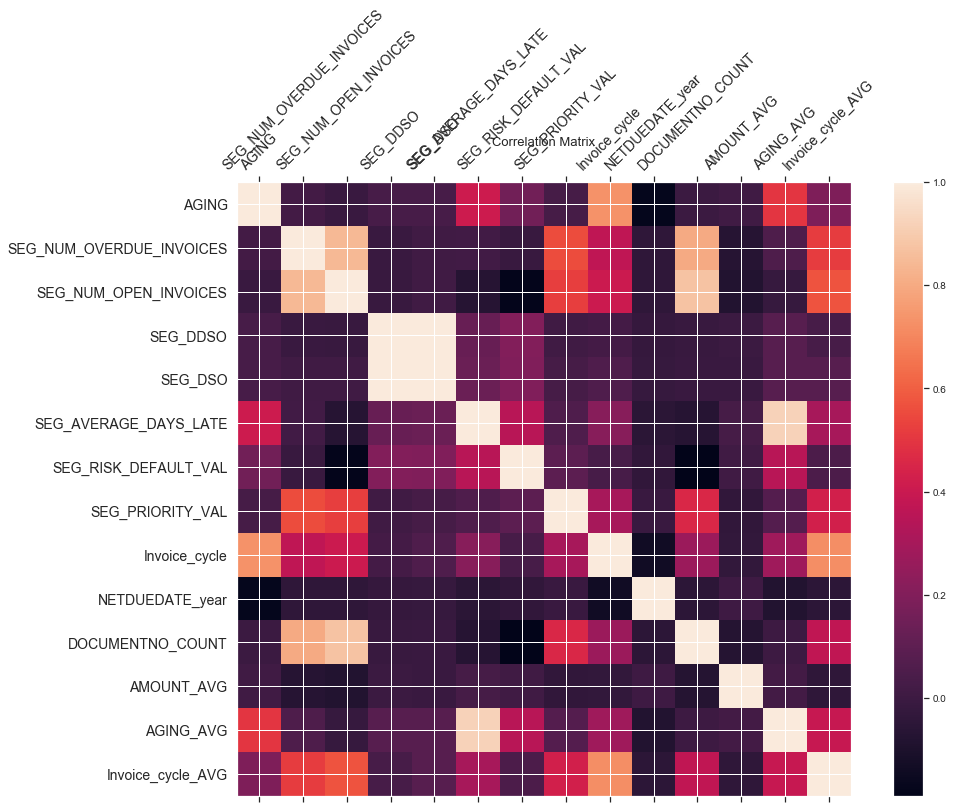

In [26]:
#Correlation Plot
f = plt.figure(figsize=(15, 11))
plt.matshow(AR_data_merg1_select1.corr(), fignum=f.number)
plt.xticks(range(AR_data_merg1_select1.shape[1]), AR_data_merg1_select1.columns, fontsize=14, rotation=45)
plt.yticks(range(AR_data_merg1_select1.shape[1]), AR_data_merg1_select1.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.title('Correlation Matrix', fontsize=13);

In [27]:
AR_data_merg1_select1.corr().loc[:,'AGING'].abs().sort_values(ascending=False)[1:]

Invoice_cycle              0.73
AGING_AVG                  0.50
SEG_AVERAGE_DAYS_LATE      0.41
Invoice_cycle_AVG          0.20
NETDUEDATE_year            0.17
SEG_RISK_DEFAULT_VAL       0.16
SEG_DSO                    0.04
SEG_DDSO                   0.04
SEG_PRIORITY_VAL           0.03
SEG_NUM_OVERDUE_INVOICES   0.02
AMOUNT_AVG                 0.01
SEG_NUM_OPEN_INVOICES      0.01
DOCUMENTNO_COUNT           0.00
Name: AGING, dtype: float64

In [28]:
##correlation between all columns and remove highly correlated ones using python or pandas
import numpy as np

# Create correlation matrix
corr_matrix = AR_data_merg1_select1.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]

In [29]:
to_drop

['SEG_NUM_OPEN_INVOICES', 'SEG_DSO', 'DOCUMENTNO_COUNT', 'AGING_AVG']

In [30]:
#dropping highly correlated independent variables
col2=['SEG_DDSO','Invoice_cycle_AVG','AMOUNT_AVG','AGING_AVG','DOCUMENTNO_COUNT','NETDUEDATE_year']
AR_omit=AR_data_merg1.drop(columns=col2,axis=1)

In [31]:
AR_omit_copy=AR_omit.copy()

In [32]:
AR_omit_copy.columns

Index(['PAY_TERM', 'AGING', 'SEG_NUM_OVERDUE_INVOICES',
       'SEG_NUM_OPEN_INVOICES', 'SEG_DSO', 'SEG_AVERAGE_DAYS_LATE',
       'SEG_RISK_DEFAULT_VAL', 'SEG_PRIORITY_VAL', 'SEG_PROP_PAY',
       'Invoice_cycle', 'AMOUNT_BUCKET'],
      dtype='object')

In [33]:
#Proportion of values as outlier in Aging
q75, q25 = np.percentile(AR_omit_copy['AGING'],[75 ,25]) 
iqr_aging = q75 - q25 

In [34]:
q75+3*iqr_aging # Upper limit cut

53.0

In [36]:
q25-1.5*iqr_aging # Upper limit cut

-35.0

# Importing Open data

In [37]:
open_raw=pd.read_csv("C:/Users/YogeshGovindan/Desktop/AVNET/Model/ar_open_item_summary1.csv",index_col=0)

C:\Users\YogeshGovindan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (53,54) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [38]:
open_raw_no_disp=open_raw[open_raw['DISPUTE_FLAG']=='NO_DISPUTE']

In [39]:
open_raw_no_disp['AMOUNT'].sum()

719814068.1144545

In [40]:
open=pd.read_csv("C:/Users/YogeshGovindan/Desktop/AVNET/Model/ar_open_reg1.csv",index_col=0) ## open regression table

In [41]:
open['AMOUNT'].sum()

719810737.9153117

In [42]:
open.shape

(270935, 24)

In [ ]:
# relative frequency of the missings per column
#missing=pd.DataFrame(open.isna().sum()/(len(open))*100)


In [ ]:
#missing

In [43]:
open['CLEARINGDA'] = pd.Timestamp('2020-10-31')

In [44]:
open['PAY_TERM'].nunique()

143

In [45]:
open['DOC_DATE']=pd.to_datetime(open['DOC_DATE'])
open['POSTINGDATE']=pd.to_datetime(open['POSTINGDATE'])
open['NETDUEDATE']=pd.to_datetime(open['NETDUEDATE'])

In [46]:
open['NETDUEDATE_year']=pd.DatetimeIndex(open['NETDUEDATE']).year

In [47]:
open['NETDUEDATE_year'].value_counts().sort_index()

2006.00         1
2007.00         1
2008.00         1
2009.00       153
2010.00       225
2011.00       221
2012.00       202
2013.00        29
2014.00        66
2015.00       126
2016.00       687
2017.00      2372
2018.00      7860
2019.00     22754
2020.00    174542
2021.00     61693
Name: NETDUEDATE_year, dtype: int64

In [48]:
open['Invoice_cycle']=open['CLEARINGDA']-open['DOC_DATE']

In [49]:
open['Invoice_cycle'] = open['Invoice_cycle'].dt.days.astype('int16')

In [50]:
open['Invoice_cycle'].mean()

142.73777105209737

In [51]:
open['AGING'].mean()

71.72499843134649

In [52]:
open['AMOUNT_BUCKET']=open.apply(lambda x:Amntbucket(x['AMOUNT']),axis=1)

In [53]:
open['AMOUNT_BUCKET'].value_counts(normalize=True)

Medium       0.46
Low_value    0.32
High_value   0.22
Name: AMOUNT_BUCKET, dtype: float64

In [54]:
open.groupby('AGING_BUCKET')['AMOUNT'].sum()/open['AMOUNT'].sum()

AGING_BUCKET
A_6 AND BEFORE DAYS    0.85
B_0 TO 5 BEFORE DAYS   0.06
C_1 TO 5 DAYS          0.03
D_6 TO 10 DAYS         0.02
E_11 TO 30 DAYS        0.02
F_31 TO 60 DAYS        0.01
G_61 TO 90 DAYS        0.00
H_>90 DAYS             0.00
Name: AMOUNT, dtype: float64

In [55]:
open_copy=pd.merge(open,cust_summary,on='CUSTOMER',how='left')

In [56]:
open_copy=open_copy.loc[:,['PAY_TERM', 'AGING', 'SEG_NUM_OVERDUE_INVOICES',
       'SEG_NUM_OPEN_INVOICES', 'SEG_DSO', 'SEG_AVERAGE_DAYS_LATE',
       'SEG_RISK_DEFAULT_VAL', 'SEG_PRIORITY_VAL', 'SEG_PROP_PAY',
       'Invoice_cycle', 'AMOUNT_BUCKET']]

# Concatting both Close and Open inorder to reslove the levelling issue

In [57]:
open_copy['Flag']='Open'

In [58]:
AR_omit['Flag']='Train'

In [59]:
close_open_concat = pd.concat([open_copy, AR_omit])

In [60]:
## Cleaning the NAN and Inf observation from the dataset
close_open_concat=close_open_concat.replace([np.inf, -np.inf], np.nan)

In [61]:
nan_values =  close_open_concat.isna()
nan_columns = nan_values.any()
columns_with_nan = close_open_concat.columns[nan_columns].tolist()

In [62]:
close_open_concat = close_open_concat.apply(lambda x:x.fillna(x.mode().iloc[0]))

In [63]:
#converting categorical variables to dummy variables
close_open_concat_dummy=pd.get_dummies(close_open_concat, prefix=['PAY_TERM','SEG_PROP_PAY','AMOUNT_BUCKET'], columns=['PAY_TERM','SEG_PROP_PAY','AMOUNT_BUCKET'])

In [64]:
AR_omit=close_open_concat_dummy[close_open_concat_dummy['Flag']=='Train']

In [65]:
AR_omit=AR_omit.drop(['Flag'], axis=1)

In [66]:
open_data=close_open_concat_dummy[close_open_concat_dummy['Flag']=='Open']

In [67]:
## Only the Aging column for validation
open_aging=open_data['AGING']

In [68]:
open_data=open_data.drop(['Flag','AGING'], axis=1)

# Building Model¶

In [69]:
#model building with omitted data
#separating input and output features
x=AR_omit.drop(['AGING'],axis='columns',inplace=False)
y=AR_omit['AGING']

In [70]:
#splitting data into test and train
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=3)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(1966599, 174) (842829, 174) (1966599,) (842829,)


In [71]:
### we are making a base model by using test data mean value. This is to set a benchmark and to compare with our regression model####

#Finding the mean for test data value
base_pred=np.mean(y_test)
print(base_pred)

-2.289392035632376


In [72]:
#Repeating same value till length of test data
base_pred=np.repeat(base_pred,len(y_test))
print(base_pred)

[-2.28939204 -2.28939204 -2.28939204 ... -2.28939204 -2.28939204
 -2.28939204]


In [73]:
#finding the RMSE
base_root_mean_square_error=np.sqrt(mean_squared_error(y_test,base_pred))
print(base_root_mean_square_error)

38.97950836055369


In [74]:
##Linear Regression as true

lgr=LinearRegression(fit_intercept=True)

In [75]:
#Model
model_lin1=lgr.fit(X_train,y_train)

In [76]:
Age_prediction_lin1=model_lin1.predict(X_test)

In [77]:
#Predicting on test set
Age_prediction_lin1=model_lin1.predict(X_test)

In [78]:
#computing MSE and RMSE
lin_mse1=mean_squared_error(y_test,Age_prediction_lin1)
lin_remse1=np.sqrt(lin_mse1)
print(lin_remse1)


10.39207329012952


In [79]:
#R squared value
r2_lin_test1=model_lin1.score(X_test,y_test)
r2_lin_train1=model_lin1.score(X_train,y_train)
print(r2_lin_test1,r2_lin_train1)

0.9289225747052573 0.929295391463273


count   842829.00
mean         0.02
std         10.39
min       -318.17
25%         -5.82
50%         -0.56
75%          2.16
max        161.20
Name: AGING, dtype: float64

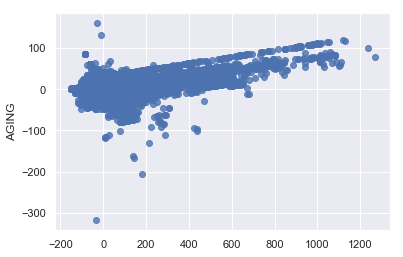

In [80]:
#Regression diagnostics-Residual plot analysis
residuals1=y_test-Age_prediction_lin1
sns.regplot(x=Age_prediction_lin1,y=residuals1,scatter=True,fit_reg=False)
residuals1.describe()

# Predicting the actual AR data

In [ ]:
#Predicting on test set
Predict_all_data=model_lin1.predict(x)

In [ ]:
#computing MSE and RMSE
lin_mse3=mean_squared_error(y,Predict_all_data)
lin_remse3=np.sqrt(lin_mse3)
print(lin_remse3)

In [ ]:
#R squared value
r2_lin_test3=model_lin1.score(x,y)
print(r2_lin_test3)

In [ ]:
#Regression diagnostics-Residual plot analysis
residuals3=y-Predict_all_data
sns.regplot(x=Predict_all_data,y=residuals3,scatter=True,fit_reg=False)
residuals3.describe()

In [ ]:
AR_Actual=ar_AR_sample.copy()

In [ ]:
AR_Actual['Predicted']=Predict_all_data

In [ ]:
AR_Actual.head()

In [ ]:
def diffbucket(predicted):
    if predicted<=(30):
        return "till 30 days"
    elif predicted>(30) and predicted<=45:
        return 'B_31 TO 45 DAYS'
    elif predicted>(45) and predicted<=60:
        return 'C_45 TO 60 DAYS'
    elif predicted>(60) and predicted<=120:
        return 'D_60 TO 120 DAYS'
    else: return 'E_>120 DAYS'

In [ ]:
AR_Actual['Pred_bucket_new']=AR_Actual.apply(lambda x:diffbucket(x['Predicted']),axis=1)

In [ ]:
AR_Actual['Actual_Bucket']=AR_Actual.apply(lambda x:diffbucket(x['AGING']),axis=1)

In [ ]:
y_test=AR_Actual['Actual_Bucket']
y_pred=AR_Actual['Pred_bucket_new']

In [ ]:
from sklearn.metrics import confusion_matrix

labels =["till 30 days", "B_31 TO 45 DAYS","C_45 TO 60 DAYS","D_>60 DAYS"]
cm = confusion_matrix(y_test, y_pred, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Concatting the prediction to the actual AR test data

In [ ]:
#splitting data into test and train
AR_train,AR_test=train_test_split(ar_AR_sample,test_size=0.3,random_state=3)
print(AR_train.shape,AR_test.shape)

In [ ]:
AR_test['Prediction']=Age_prediction_lin1

In [ ]:
AR_test['AGING_BUCKET'].value_counts(normalize=True)

In [ ]:
AR_test.groupby('AGING_BUCKET')['AMOUNT'].sum()/AR_test['AMOUNT'].sum()

In [ ]:
def diffbucket(predicted):
    if predicted<=(-6):
        return "A_6 AND BEFORE DAYS"
    elif predicted>(-6) and predicted<=0:
        return 'B_0 TO 5 BEFORE DAYS'
    elif predicted>0 and predicted<=5:
        return 'C_1 TO 5 DAYS'
    elif predicted>5 and predicted<=10:
        return 'D_6 TO 10 DAYS'
    elif predicted>10 and predicted<=30:
        return 'E_11 TO 30 DAYS'
    elif predicted>30and predicted<=60:
        return 'F_31 TO 60 DAYS'
    elif predicted>60 and predicted<=90:
        return 'G_61 TO 90 DAYS'
    else: return 'H_>90 DAYS'

In [ ]:
AR_test['Pred_bucket']=AR_test.apply(lambda x:diffbucket(x['Prediction']),axis=1)

In [ ]:
AR_test.groupby('Pred_bucket')['AMOUNT'].sum()/AR_test['AMOUNT'].sum()

In [ ]:
def diffbucket(predicted):
    if predicted<=(-6):
        return "A_6 AND BEFORE DAYS"
    elif predicted>(-6) and predicted<=0:
        return 'B_0 TO 5 BEFORE DAYS'
    elif predicted>0 and predicted<=30:
        return 'C_1 TO 30 DAYS'
    else: return 'H_>30 DAYS'

In [ ]:
def diffbucket(predicted):
    if predicted<=(7):
        return "till 7 days"
    else: return 'H_>7 DAYS'

In [ ]:
AR_test['Pred_bucket_new']=AR_test.apply(lambda x:diffbucket(x['Prediction']),axis=1)

In [ ]:
AR_test['AGing_Bucket_new']=AR_test.apply(lambda x:diffbucket(x['AGING']),axis=1)

In [ ]:
y_test=AR_test['AGing_Bucket_new']
y_pred=AR_test['Pred_bucket_new']

In [ ]:
from sklearn.metrics import confusion_matrix

labels =["till 7 days", "H_>7 DAYS"]
cm = confusion_matrix(y_test, y_pred, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
#a_test.to_csv("C:/Users/YogeshGovindan/Desktop/AVNET/Model/test_ouput.csv")

# Predicting the Open Data set

In [162]:
def diffbucket(predicted):
    if predicted<=(30):
        return "till 30 days"
    elif predicted>(30) and predicted<=45:
        return 'B_31 TO 45 DAYS'
    elif predicted>(45) and predicted<=60:
        return 'C_45 TO 60 DAYS'
    elif predicted>(60) and predicted<=120:
        return 'D_60 TO 120 DAYS'
    else: return 'E_>120 DAYS'

In [81]:
#Predicting on test set
Age_Open_pred_lin=model_lin1.predict(open_data)

In [82]:
#computing MSE and RMSE
lin_mse2=mean_squared_error(open_aging,Age_Open_pred_lin)
lin_remse2=np.sqrt(lin_mse2)
print(lin_remse2)

51.914020882211354


count   270935.00
mean        17.71
std         48.80
min       -285.07
25%         -4.64
50%          0.33
75%         18.03
max       3144.97
Name: AGING, dtype: float64

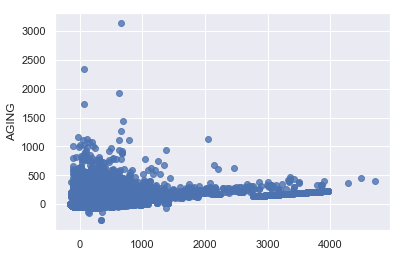

In [83]:
#Regression diagnostics-Residual plot analysis
residuals2=open_aging-Age_Open_pred_lin
sns.regplot(x=Age_Open_pred_lin,y=residuals2,scatter=True,fit_reg=False)
residuals2.describe()

In [84]:
#R squared value
r2_lin_test1=model_lin1.score(open_data,open_aging)

print(r2_lin_test1)

0.9732500003737153


# Concating with the Raw_Open data

In [148]:
open_raw_copy=open_raw_no_disp.copy()

In [149]:
open_raw_copy['DOC_DATE']=pd.to_datetime(open_raw_copy['DOC_DATE'])
open_raw_copy['POSTINGDATE']=pd.to_datetime(open_raw_copy['POSTINGDATE'])
open_raw_copy['NETDUEDATE']=pd.to_datetime(open_raw_copy['NETDUEDATE'])
open_raw_copy['CLEARINGDA']=pd.to_datetime(open_raw_copy['CLEARINGDA'])

In [ ]:
#open_raw_copy['NETDUEDATE'] = open_raw_copy['NETDUEDATE'].replace(np.nan, 0)

In [150]:
open_raw_copy['NETDUEDATE']=pd.to_datetime(open_raw_copy['NETDUEDATE'])

In [151]:
open_raw_copy['NETDUEDATE_year']=pd.DatetimeIndex(open_raw_copy['NETDUEDATE']).year

In [152]:
open_raw_copy['NETDUEDATE_year'].value_counts().sort_index()

2006.00         1
2007.00         1
2008.00         1
2009.00       153
2010.00       225
2011.00       221
2012.00       202
2013.00        29
2014.00        66
2015.00       126
2016.00       687
2017.00      2372
2018.00      7860
2019.00     22754
2020.00    174542
2021.00     61693
Name: NETDUEDATE_year, dtype: int64

In [153]:
open_raw_copy['predicted']=Age_Open_pred_lin

In [154]:
open_raw_copy['open_date']=pd.Timestamp('2020-10-31')

In [155]:
open_raw_copy['predicted1']=np.where(open_raw_copy['predicted']>120,120,open_raw_copy['predicted'])

In [164]:
open_raw_copy['Pred_bucket']=open_raw_copy.apply(lambda x:diffbucket(x['predicted1']),axis=1)

In [166]:
open_raw_copy['Pred_bucket'].value_counts(normalize=True)

till 30 days       0.79
D_60 TO 120 DAYS   0.19
C_45 TO 60 DAYS    0.01
B_31 TO 45 DAYS    0.01
Name: Pred_bucket, dtype: float64

In [156]:
open_raw_copy["Pred_clearing_date"] = pd.to_datetime(open_raw_copy["NETDUEDATE"]) + pd.to_timedelta(open_raw_copy['predicted1'], unit='D')

In [157]:
open_raw_copy["Pred_clearing_date1"]=np.where(open_raw_copy["Pred_clearing_date"]<open_raw_copy['open_date'],open_raw_copy['open_date']+pd.to_timedelta(-15,unit='D'),open_raw_copy["Pred_clearing_date"])

In [158]:
open_raw_copy['Pred_clearing_date_year1']=pd.DatetimeIndex(open_raw_copy['Pred_clearing_date1']).year

In [161]:
open_raw_copy['Pred_clearing_date_year1'].value_counts(normalize=True)

2020.00   0.77
2021.00   0.23
Name: Pred_clearing_date_year1, dtype: float64

# Returns the week of the month for the specified date

In [ ]:
from math import ceil

def week_of_month(dt):
    """ Returns the week of the month for the specified date.
    """

    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))

In [ ]:
open_raw_copy['Week_predicted']=open_raw_copy.apply(lambda x:week_of_month(x['Pred_clearing_date']),axis=1)

In [ ]:
open_raw_copy['DOCUMENTNO']=open_raw_copy['DOCUMENTNO'].apply(str)

In [ ]:
open_raw_copy['ITEMNO']=open_raw_copy['ITEMNO'].apply(str)

In [ ]:
open_predction=open_raw_copy.loc[:,['DOCUMENTNO','DOC_DATE','PAY_TERM','NETDUEDATE','ITEMNO','AGING','predicted','Pred_bucket','Pred_clearing_date', 'Week_predicted']]

In [ ]:
open_predction.dtypes

In [ ]:
open_predction['Pred_clearing_date'] = pd.to_datetime(open_predction['Pred_clearing_date']).dt.date

In [ ]:
Actual_aging=open_predction[open_predction['AGING']>120]

In [ ]:
open_predction['Pred_clearing_date']=pd.to_datetime(open_predction['Pred_clearing_date'])

In [ ]:
open_predction['pred_year']=pd.DatetimeIndex(open_predction['Pred_clearing_date']).year

In [ ]:
open_predction['NETDUEDATE_year']=pd.DatetimeIndex(open_predction['NETDUEDATE']).year

In [ ]:
open_predction['pred_year'].value_counts().sort_index()

In [ ]:
open_predction['AGING'].describe()

In [ ]:
Actual_aging=open_predction[open_predction['AGING']>120]

In [ ]:
Actual_aging.shape

In [ ]:
open_predction['predicted'].describe()

In [ ]:
predicted_aging=open_predction[open_predction['predicted']>120]

In [ ]:
predicted_aging.shape

In [ ]:
newdf = open_predction[(open_predction.Pred_bucket=='E_>120 DAYS')]

In [ ]:
open_predction.dtypes

In [ ]:
newdf['pred_year'].value_counts().sort_index()

In [ ]:
newdf_negative = newdf [(newdf .predicted<0)]

In [ ]:
from datetime import timedelta

In [ ]:
open_predction.dtypes

In [ ]:
greater_netduedate=open_predction[(open_predction['NETDUEDATE']>"2021-02-21")]

In [ ]:
greater_netduedate['predicted'].describe()

In [ ]:
greater_netduedate.shape

In [ ]:
outlier_date.shape

In [ ]:
open_predction.shape

In [ ]:
#newdf.to_csv("C:/Users/YogeshGovindan/Desktop/AVNET/Model/year_2030_case.csv")

In [ ]:
open_predction['NETDUEDATE_year'].value_counts().sort_index()

In [ ]:
open_predction.head()

# Loadin the output to DB

In [ ]:
tuple_of_tuples = tuple([tuple(x) for x in open_predction.values])


In [ ]:
load_db2_sql = "INSERT INTO avent.ar_open_prediction_Agg VALUES(?,?,?,?)"
print(load_db2_sql)

In [ ]:
stmt = ibm_db.prepare(conn, load_db2_sql)


In [ ]:
ibm_db.execute_many(stmt, tuple_of_tuples)

# Pickle#####

In [ ]:
import os

In [ ]:
os.getcwd()

In [ ]:
import joblib

In [ ]:
#joblib.dump(model_lin1,'linearmodel')  ## Run this code when there is any changes in the train dataset. When the model is trained run this code and copy the file from the 'getcwd' and save the file in your respective directory

In [ ]:
mp=joblib.load('C:/Users/YogeshGovindan/Desktop/AVNET/Model/linearmodel')

In [ ]:
#Predicting on test set
Age_Open_pred_lin1=mp.predict(open_data)

In [ ]:
#computing MSE and RMSE
lin_mse2=mean_squared_error(open_aging,Age_Open_pred_lin1)
lin_remse2=np.sqrt(lin_mse2)
print(lin_remse2)

In [ ]:
#Regression diagnostics-Residual plot analysis
residuals2=open_aging-Age_Open_pred_lin1
sns.regplot(x=Age_Open_pred_lin1,y=residuals2,scatter=True,fit_reg=False)
residuals2.describe()

In [ ]:
#R squared value
r2_lin_test1=mp.score(open_data,open_aging)

print(r2_lin_test1)

In [ ]:
result = pd.concat([open_aging,open],axis=1)

In [ ]:
result['predicted']=Age_Open_pred_lin1

In [ ]:
result['AGING_BUCKET'].value_counts(normalize=True).sort_index()

In [ ]:
def diffbucket(predicted):
    if predicted<=(-6):
        return "A_6 AND BFORE"
    elif predicted>=(-5) and predicted<=0:
        return 'B_0-5 BEFORE'
    elif predicted>=1 and predicted<=5:
        return 'C_1-5'
    elif predicted>=6 and predicted<=10:
        return 'D_6-10'
    elif predicted>=11 and predicted<=30:
        return 'E_11-30'
    elif predicted>=31 and predicted<=60:
        return 'F_31-60 '
    elif predicted>=61 and predicted<=90:
        return 'G_61-90 '
    elif predicted>=91 and predicted<=120:
        return 'H_91-120 '
    else: return 'I_121+'

In [ ]:
result['Pred_bucket']=result.apply(lambda x:diffbucket(x['predicted']),axis=1)

In [ ]:
result['Pred_bucket'].value_counts(normalize=True).sort_index()

In [ ]:
result['prd_date']=result['NETDUEDATE']+pd.to_timedelta(result['predicted'],unit='d')

In [ ]:
result.dtypes

In [ ]:
validation=result.loc[:,['DOCUMENTNO','DOC_DATE','NETDUEDATE','AGING','AGING_BUCKET','predicted','Pred_bucket','prd_date']]

In [ ]:
validation.head()

In [ ]:
validation['Pred_bucket'].value_counts(normalize=True).sort_index()

In [ ]:
validation['flag']=np.where(validation['prd_date'] >=  pd.Timestamp('2020-10-26'),True,False)

In [ ]:
validation['flag'].value_counts(normalize=True).sort_index()

In [ ]:
validation['prd_date'].min()

In [ ]:
pd.crosstab(validation['Pred_bucket'], validation['flag'])

In [ ]:
validation['Preddatevsdocdate']=np.where(validation['DOC_DATE'] >=  validation['NETDUEDATE'],True,False)

In [ ]:
validation['Preddatevsdocdate'].value_counts(normalize=True)